In [1]:
from __future__ import annotations
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.3f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [ ]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')
master.head()

In [ ]:
from util_funcs import do_basic_formatting
from util_funcs import do_basic_filtering
from util_funcs import remove_identical_primary_secondary_cases

print('\nFiltering')
maintable = do_basic_filtering(master.copy(), filter_mets='brain')
maintable = remove_identical_primary_secondary_cases(maintable)

print('\nFormatting')
maintable = do_basic_formatting(maintable)
maintable.head()


Filtering
Reginning records: 5604583
Removing records not in range (2010, 2020)... removed 371509 records
Removing records with non 'MALIGNANT' behavior... removed 632160 records
Handling patients with multiple records of same cancer_type... removed 82397 records
Removing records where brain_met value is missing
- removed 695869 records

Final records: 3822648, patients: 3620282
Removing MET records where primary tissue is identical to secondary tissue
- removed 67488 records

Formatting
Missing 0 codes.
Formatting cancer subtypes
TNG, Grade standardisation


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,other_met,distant_ln,any_met,hist_group,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD
4,139,"2,011.000",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.000,0.000,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NaN,NaN,NO,ductal and lobular neoplasms,Infiltrating duct carcinoma [+ others],T3,N0,II,G3
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.000,0.000,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,False,NO,ductal and lobular neoplasms,Infiltrating duct carcinoma [+ others],T2,N0,II,G3
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.000,0.000,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,False,NO,"cystic, mucinous and serous neoplasms",Serous carcinoma [+ others],T1,N0,I,G2
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.000,NaN,MALIGNANT,2,0,6.600,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,adenomas and adenocarcinomas,Adenoma [+ others],T1,N0,II,G2
8,265,"2,016.000",2011,2016,65-69 years,Prostate,Prostate,Prostate,Prostate,T2c,N0,II,NaN,NaN,NaN,G3,NaN,NaN,0.000,NaN,MALIGNANT,2,0,7.700,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NaN,NaN,NO,adenomas and adenocarcinomas,Adenoma [+ others],T2,N0,II,G3


PREVALENCE

In [ ]:
### PREVALENCE ###
# calculate prevalences per cancer_group.
# brain case load, plus brain/bone/lung/liver met rates

# from util_funcs import calculate_logodds
from util_funcs import calculate_prevalence
from util_funcs import calculate_relrisk
from util_funcs import select_valid

FEATURE = 'cancer_group:hist_group'
maintable[FEATURE] = maintable['cancer_group'] + ':' + maintable['hist_group']
MIN_RECORDS = 5000
SEC_FEATURES = {'brain_met'}
SEC_MINCOUNT = 20
VALID_FEATURES = select_valid(maintable, feature=FEATURE, min_records=MIN_RECORDS, sec_features=SEC_FEATURES, sec_mincount=SEC_MINCOUNT)

# otable = calculate_logodds(feature=FEATURE, valid=VALID_FEATURES, response='brain_met', table=maintable)
ptable = calculate_prevalence(FEATURE, VALID_FEATURES, 'brain_met', maintable)
rtable = calculate_relrisk(FEATURE, VALID_FEATURES, 'brain_met', maintable)
mtable = calculate_relrisk(FEATURE, VALID_FEATURES, 'brain_met', maintable[maintable['any_met']=='YES'])


In [23]:
assert set(ptable.index) == set(rtable.index)
assert set(rtable.index) == set(mtable.index)
stat_frame = ptable.copy()
stat_frame['relRisk'] = mtable['relRisk']
stat_frame['relRiskLow'] = mtable['relRiskLow']
stat_frame['relRiskHigh'] = mtable['relRiskHigh']
stat_frame = stat_frame.sort_values('prevalence (%)', ascending=False)
stat_frame = stat_frame.reset_index()
print(stat_frame)


                                                cancer_group:hist_group      NO    YES  records  prevalence (%)  relRisk  relRiskLow  relRiskHigh
0                                Lung and Bronchus:epithelial neoplasms   86047  15186   101233          15.001   42.766      31.519       58.026
1                        Lung and Bronchus:adenomas and adenocarcinomas  161000  22638   183638          12.328   48.331      35.624       65.570
2                               Lung and Bronchus:unspecified neoplasms   17143   2078    19221          10.811   41.408      30.465       56.282
3               Lung and Bronchus:cystic, mucinous and serous neoplasms    5041    347     5388           6.440   41.839      30.480       57.431
4                            Miscellaneous:adenomas and adenocarcinomas    6088    343     6431           5.334   11.688       8.478       16.114
5                             Lung and Bronchus:squamous cell neoplasms   86984   4217    91201           4.624   33.392    

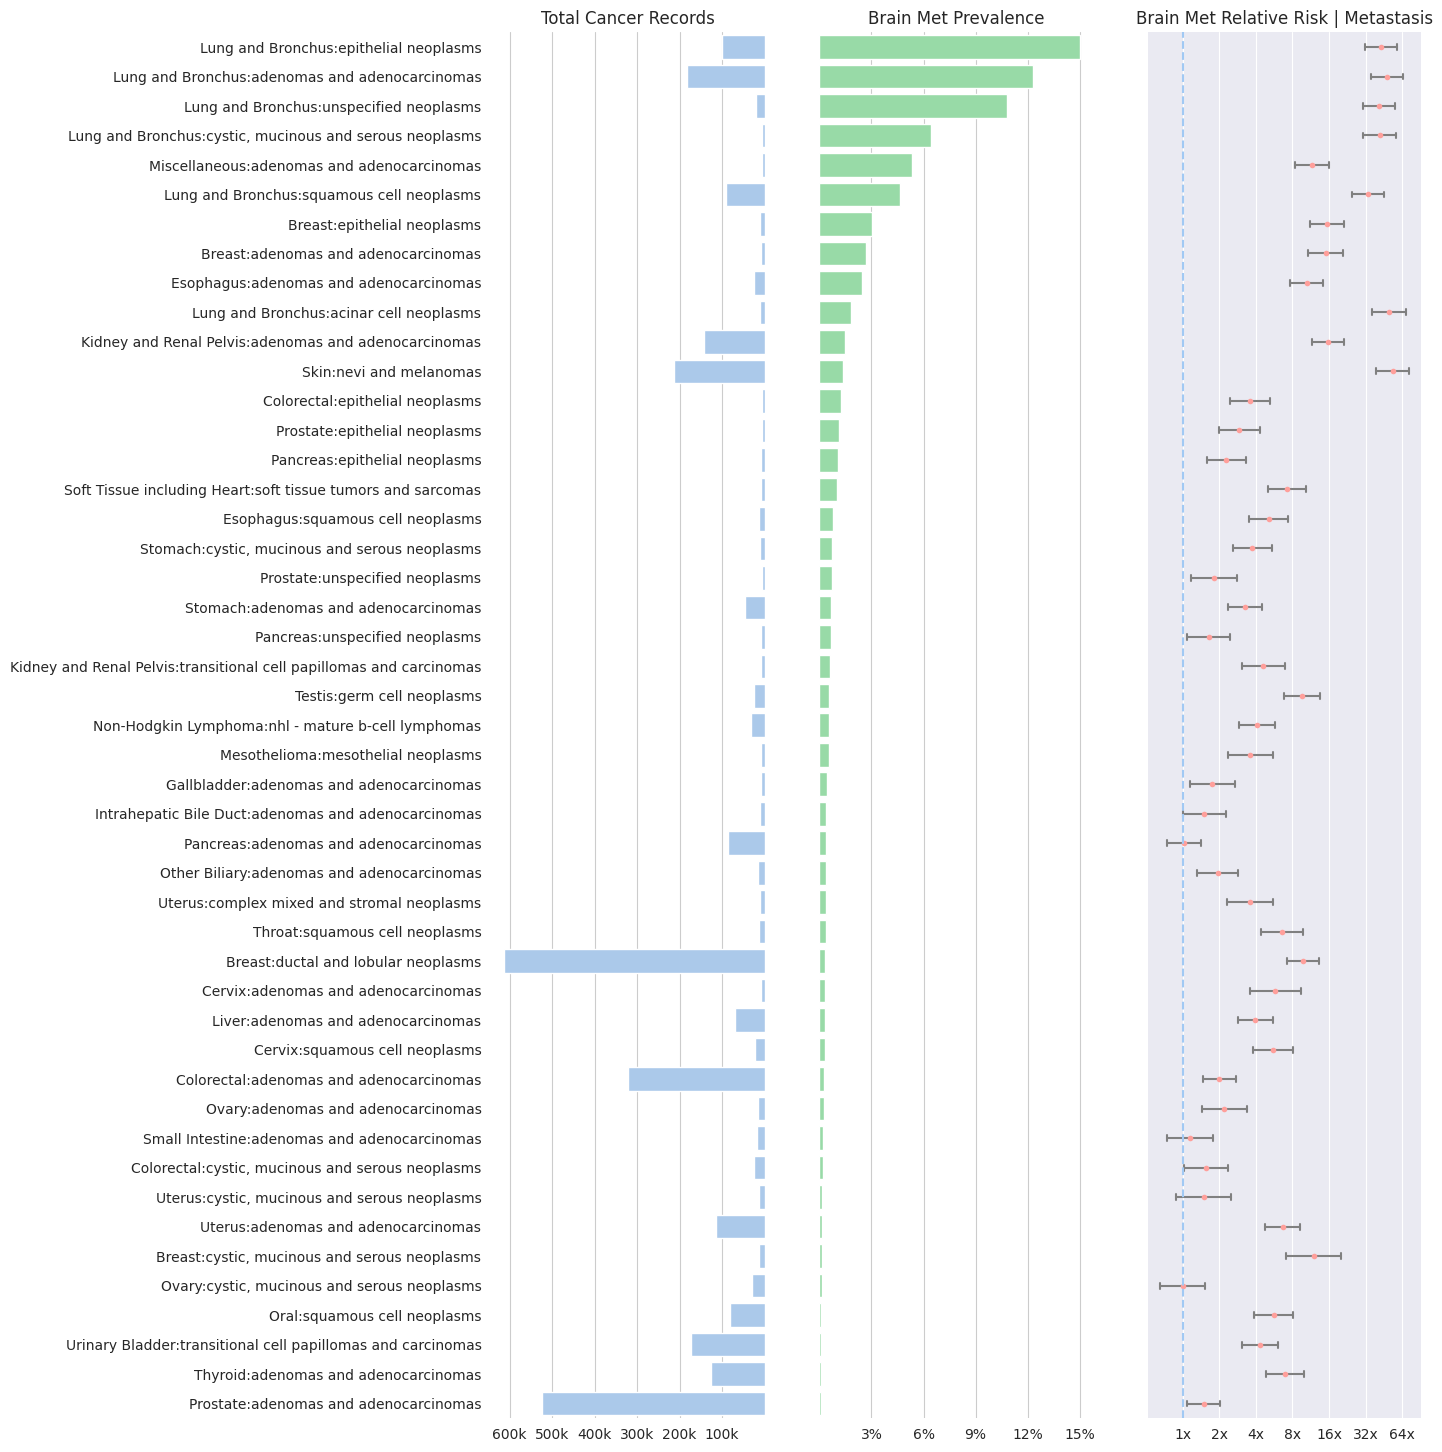

In [25]:

# Initialize the matplotlib figure
# sns.set_theme(style="whitegrid")
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 16), width_ratios=[3, 2, 3], sharey=True)
# ax1 = axes[0]
# ax2 = axes[1]
# ax3 = axes[2]

sns.set_color_codes("pastel")

fig = plt.figure(figsize=(12, 18))
gs = fig.add_gridspec(1, 3)

### Cases Subplot ###
with sns.axes_style("whitegrid"):
    ax1 = fig.add_subplot(gs[0])
    sns.barplot(data=stat_frame, x="records", y=FEATURE, color="b", ax=ax1)

### Prevalence Subplot ###
with sns.axes_style("whitegrid"):
    ax2 = fig.add_subplot(gs[1], sharey=ax1)
    sns.barplot(data=stat_frame, x="prevalence (%)", y=FEATURE, color="g", ax=ax2, legend=False)

### Odds Ratio Subplot ###
with sns.axes_style("darkgrid"):
    ax3 = fig.add_subplot(gs[2], sharey=ax1)

    def plot_ci(y: int, low: float, high: float, ax) -> None:
        height = 0.2
        color = 'grey'
        cap_top = y + height / 2
        cap_bot = y - height / 2
        ax.plot([low, high], [y, y], color=color)
        ax.plot([low, low], [cap_bot, cap_top], color=color)
        ax.plot([high, high], [cap_bot, cap_top], color=color)

    for i, row in stat_frame.iterrows():
        plot_ci(y=i, low=row['relRiskLow'], high=row['relRiskHigh'], ax=ax3)
    
    sns.pointplot(
        data=stat_frame, x="relRisk", y=FEATURE,  errorbar=None, 
        linestyle="none", marker="o", ax=ax3, legend=False, capsize=.4,
        color='r', markersize=2, 
    )

ax3.axvline(1, c='b', ls='--')
ax3.set_xscale('log')

### Aesthetics ###
ax1.set_title('Total Cancer Records')
ax2.set_title('Brain Met Prevalence')
ax3.set_title('Brain Met Relative Risk | Metastasis')

# ax1
xticks1 = [100_000, 200_000, 300_000, 400_000, 500_000, 600_000]
xlabels1 = [f"{x//1000}k" for x in xticks1]
# xticks1 = [300_000, 600_000, 900_000, 1_200_000, 1_500_000]
# xlabels1 = [f"{x//1000}k" if x <1_000_000 else f"{x/1_000_000:.1f}m" for x in xticks1]
ax1.set_xticks(xticks1, xlabels1)
ax1.invert_xaxis()

# ax2
# xticks2 = [2, 4, 6, 8, 10]
xticks2 = [3, 6, 9, 12, 15]
xlabels2 = [f"{x}%" for x in xticks2]
ax2.set_xticks(xticks2, xlabels2)
plt.setp(ax2.get_yticklabels(), visible=False)
# ax2.set_yticks([], [])

# ax3
xticks3 = [1, 2, 4, 8, 16, 32, 64]
xlabels3 = [f"{x}x" for x in xticks3]
ax3.set_xticks(xticks3, xlabels3)
plt.setp(ax3.get_yticklabels(), visible=False)
# ax2.set_yticks([], [])

# all axes
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    sns.despine(left=True, bottom=True, ax=ax)

# moving odds plot
# box = ax3.get_position()
# box.x0 = box.x0 - 0.02
# box.x1 = box.x1 - 0.02
# ax3.set_position(box)

plt.show()
